## Table of contents

1. <a href="#LoadTheLibs">Load the libraries</a>
2. <a href="#LoadTheData">Load and describe the data</a>
3. <a href="#univariate">Univariate analysis</a>
4. <a href="#bivariate">Bivariate analysis</a>
5. <a href="#preprocess">Preprocess data</a>
6. <a href="#splitAndEncode">Split and encode data</a>
7. <a href="#modelBuilding">Model building</a>
8. <a href="#featureImportance">Feature Importance</a>
9. <a href="#precisionRecall">Precision and recall considerations</a>
10. <a href="#rocCurves">ROC AUC Curve</a>
11. <a href="#hyperparameter">Hyperparameter tuning</a>
12. <a href="#conclusion">Conclusion</a>    

<a id  = LoadTheLibs></a>
## Load the libraries

In [1]:
# Linear algebra and data processing
import numpy as np
import pandas as pd

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# Set up options
%matplotlib inline
pd.set_option('display.max_columns', None)

<a id  = LoadTheData></a>
## Load and describe the data

In [3]:
#Load the dataset
cols=['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 
       'previous', 'poutcome', 'target']
bank_data = pd.read_csv('bank-full.csv', names=cols, low_memory=False, header=None, skiprows=1)

# Check the size of the dataset
print(f"This dataset contains {bank_data.shape[0]} rows and {bank_data.shape[1]} columms")

This dataset contains 45211 rows and 17 columms


In [4]:
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
# Describe the numeric features
bank_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


In [6]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


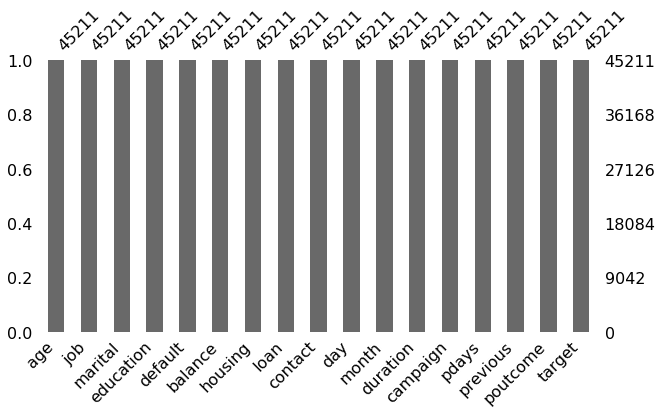

In [7]:
#Check for missing data informations across all columns
msno.bar(bank_data,figsize=(10,5));

In [8]:
#Check if dates are valid
maxDaysDict = {'jan': 31, 'feb': 28, 'mar': 31, 'apr': 30, 'may': 31, 'jun': 30, 
               'jul': 31, 'aug': 31, 'sep': 30, 'oct': 31, 'nov': 30, 'dec': 31}

bank_data[bank_data[['day', 'month']].apply(lambda x: maxDaysDict.get(x[1]) >= x[0], axis=1) == False].empty

True

#### Analysis

1. There are 17 columns out of which 10 are categorical although day can be considered as a categorical columns
2. The features can be divided in following categories <br />
<b>Features that describe customer segments</b>
       - Age
       - Job
       - Marital
       - Education
       - Default
       - Balance
       - Housing
       - Loan
<b>Features that describe banks communication </b>
       - Contact
       - Day
       - Month
       - Duration
<b>Features that describe the campaign and data about previous campaign</b>
       - Campaign
       - pdays
       - previous
       - poutcome
<b>Target features</b>
       - target
3. There does not appear to be any missing or null data
4. Mean age segment is 41 while data considers age segment between 18 and 95.
5. Balance mean is 1360 but standard deviation is quite high meaning the data is highly distributed

<a id  = univariate></a>
## Univariate analysis

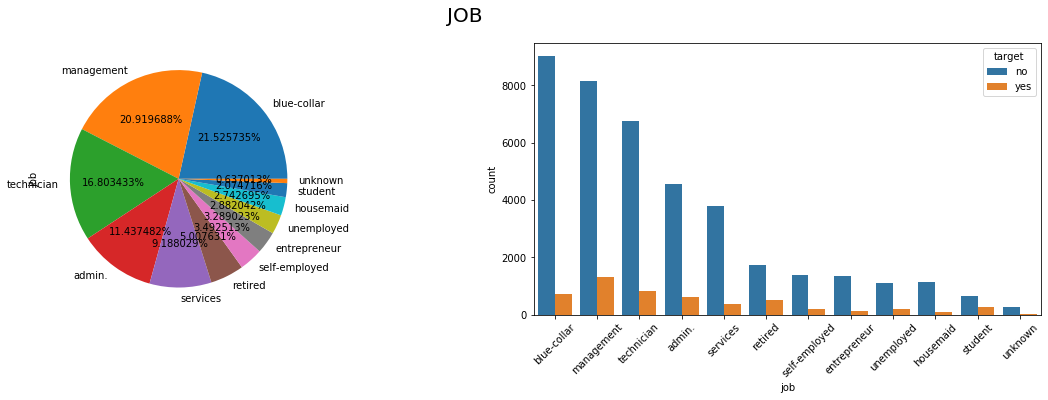

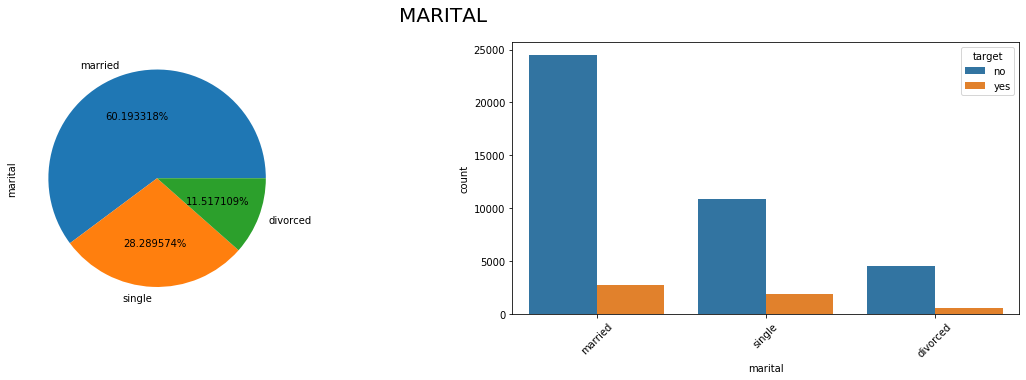

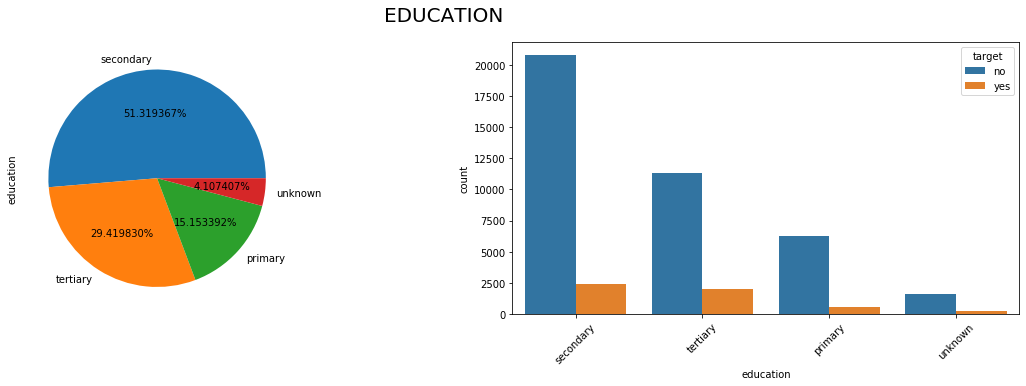

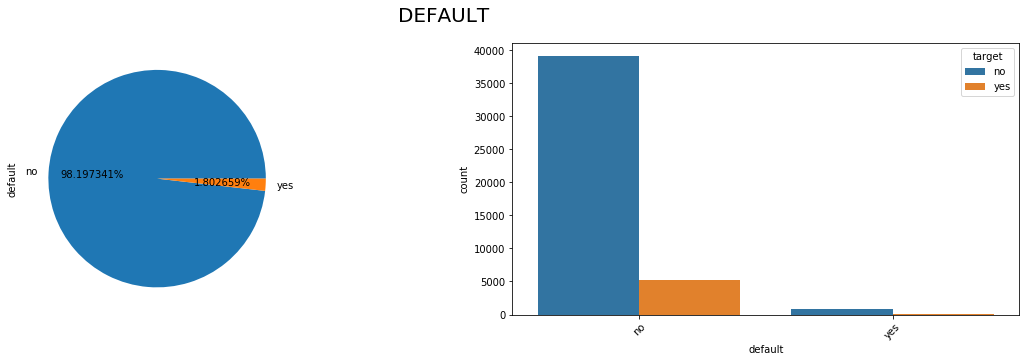

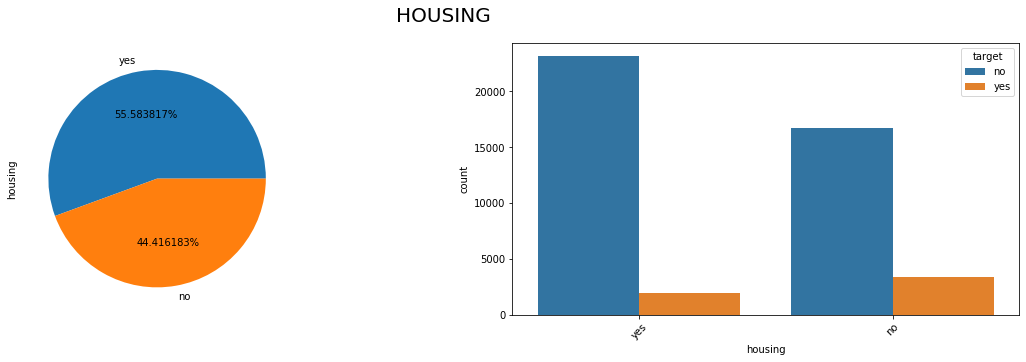

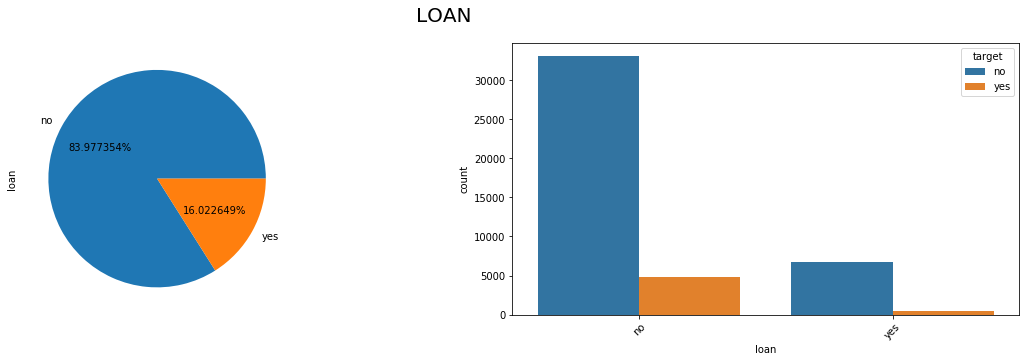

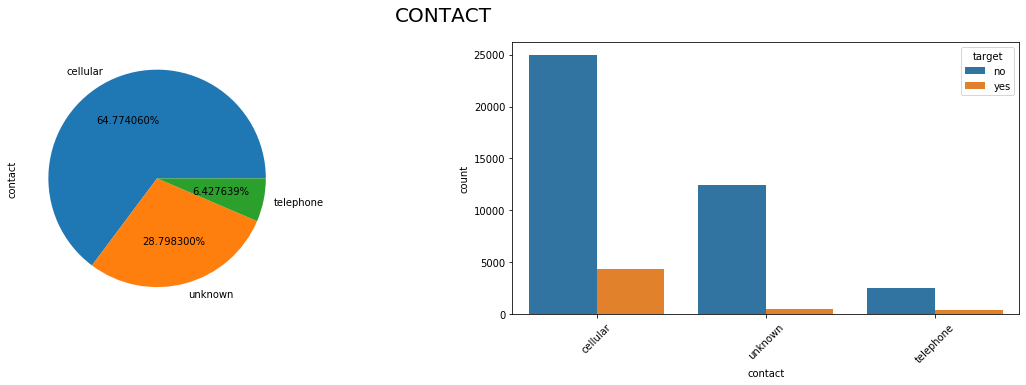

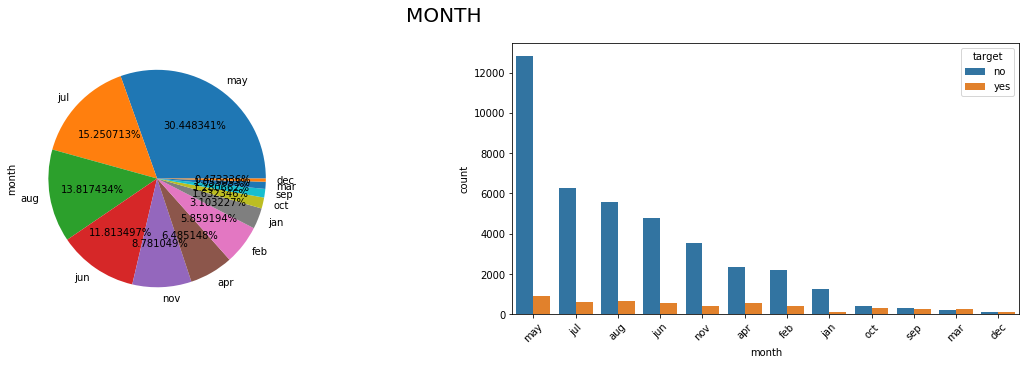

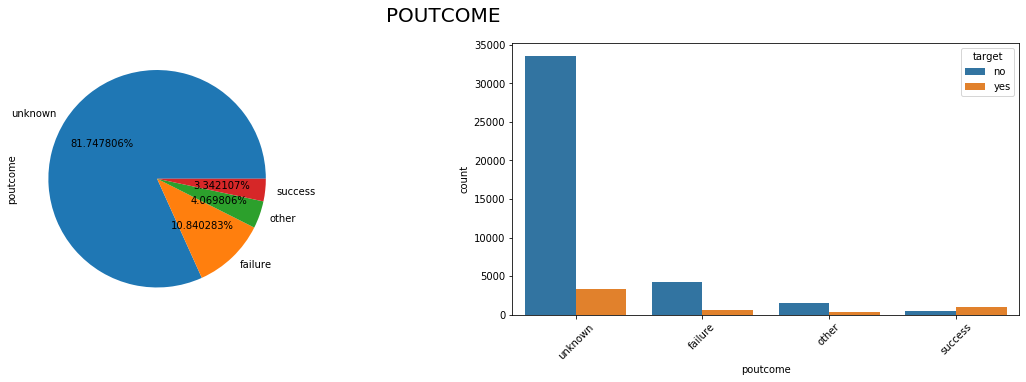

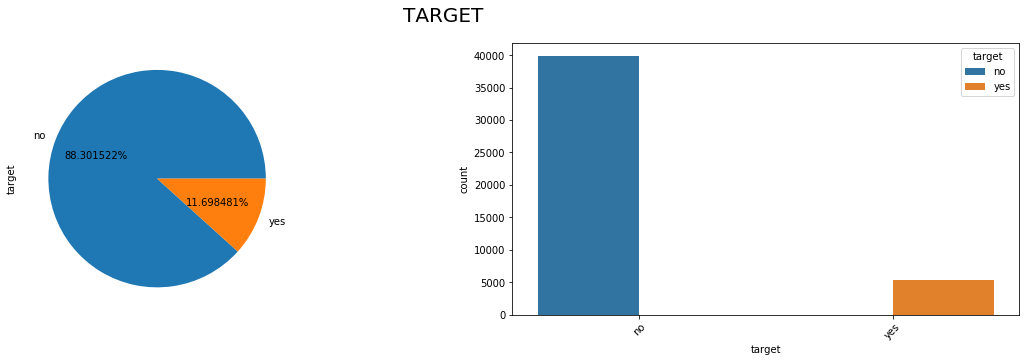

In [9]:
def cat_plots(data, feature, target, title):
    fig, ax = plt.subplots(figsize=(20, 5), nrows=1, ncols=2)
    plt.suptitle(title, fontsize=20)
    data[feature].value_counts().plot.pie(autopct='%3f%%', ax=ax[0])
    a = sns.countplot(data=data, x=feature, hue=target, ax=ax[1], order=data[feature].value_counts().index)
    plt.setp(a.get_xticklabels(), rotation=45)
    ;
    
for feature in bank_data.columns:
    if bank_data[feature].dtype == 'object':
        cat_plots(bank_data, feature, 'target', feature.upper())

### Analysis
<b>Categorical data analysis</b>
1. Target data is highly biased towards the outcome 'no'
2. As expected, jobs like management, technicians are more likely to open the deposit than retired, housemaid
3. More than half the customers being contacted in the campaign are married
4. Distribution of education is as expected. Secondary education is most common
5. Credit card default not very common as per the dataset
6. As per the dataset, those who do not have a housing loan are more likely to open a term deposit
7. Primary method of contact used in the campaign is cellular
8. Loan information is biased towards. In the dataset, 83% of the population does not have a personal loan.
9. 29% of contact data is unknown but unknown is a valid value, thus there is no need to impute/replace the values
10. 81% of poutcome data is unknonwn but since unknown is a valid value, we do not need to impute/replace it.

Because of the bias in data, we might need to to use stratified sampling to properly distribute data between training data and testing data. We can use 'loan' feature for the purpose

<a id  = bivariate></a>
## Bivariate/Multivariate analysis

In [10]:
# Label encode data for a proper analysis
from sklearn.preprocessing import LabelEncoder

fcat = [i for i in bank_data.columns if str(bank_data[i].dtype) == 'object']
fnum = [i for i in bank_data.columns if str(bank_data[i].dtype) != 'object']

lEncoder = LabelEncoder()
encoded = bank_data[fcat].apply(lEncoder.fit_transform)

num_bank_data = bank_data[fnum].join(encoded)

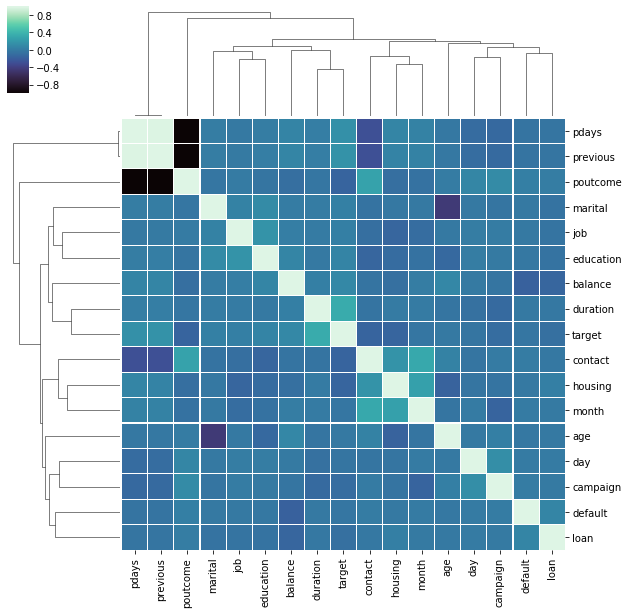

In [11]:
corrmat = num_bank_data.corr(method='spearman')
cg = sns.clustermap(corrmat, cmap="mako", linewidths=0.1);
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg

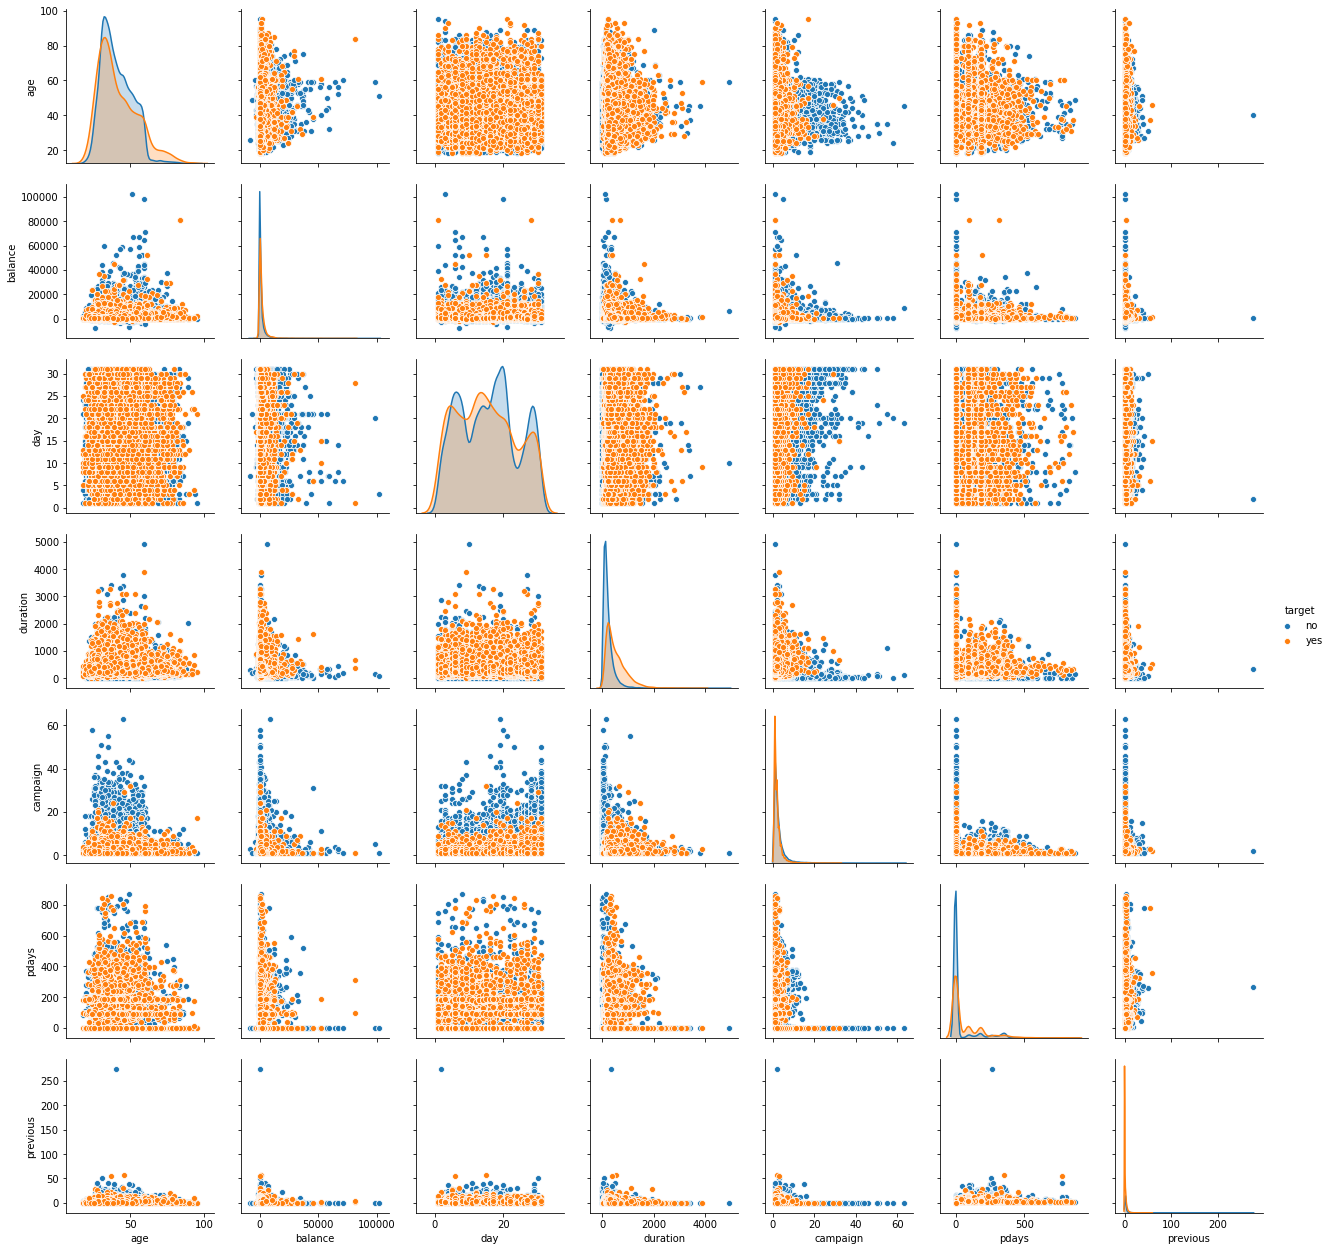

In [12]:
sns.pairplot(bank_data, hue='target')

### Analsysis
1. pdays is very highly (corr = 0.8) correlated with poutcome
2. previous is very hightly(corr=0.8) correlated with poutcome
3. As expected age and marital status are highly correlated (corr = 0.4)

Conclusion:
1. Highly correlated attributes might affect the models.

<a id  = preprocess></a>
## Preprocess the data
1. Remove the column "Duration" as per the problem statement
2. Update the column "pDays" as per the problem statement

In [13]:
#Remove duration column
bank_data.drop('duration', axis=1, inplace=True)

#Change pDays=999 where pDays= -1
bank_data.loc[bank_data['pdays'] == -1, 'pdays']= 999

<a id  = splitAndEncode></a>
## Split and encode data
In the below section, 
1. We first encode the categorical data with label encoder
2. Then we perform the split using Stratified Sampling on loan column as confirmed by EDA
3. Then we perform Standard Scaling for the numerical data since columns like balance have high standard deviation

The order of these operations is important because if we perform split before encoding, we might corrupt the data

In [14]:
# Import required libraries
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

#Identify categorical and numerical columns
fcat = [i for i in bank_data.columns if str(bank_data[i].dtype) == 'object']
fnum = [i for i in bank_data.columns if str(bank_data[i].dtype) != 'object']    

# Init required objects
standardScaler = StandardScaler()
labelEncoder = LabelEncoder()

In [15]:
# Join the tmpDF with label encoded categorical data and save it back to bank_data
bank_data = bank_data[fnum].join(bank_data[fcat].apply(labelEncoder.fit_transform))

In [16]:
display(bank_data.shape) # Check that all data is transformed
display(bank_data.isnull().sum().sum()) # Check that we did the re-indexing right

(45211, 16)

0

In [17]:
# Split the data to train and test sets
from sklearn.model_selection import StratifiedShuffleSplit

stratified = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_set, test_set in stratified.split(bank_data, bank_data["loan"]):
    stratified_train = bank_data.loc[train_set]
    stratified_test = bank_data.loc[test_set]
    
stratified_train["loan"].value_counts()/len(bank_data)
stratified_test["loan"].value_counts()/len(bank_data)

0    0.251952
1    0.048064
Name: loan, dtype: float64

In [18]:
tmpDF = pd.DataFrame(
    standardScaler.fit_transform(stratified_train[fnum]), columns=stratified_train[fnum].columns
)
# Reset the index properly since the scalar provides a matrix and when we convert it to Dataframe, index data is lost
tmpDF['index'] = stratified_train.index
tmpDF.set_index('index', inplace=True)

stratified_train = stratified_train[fcat].join(tmpDF)

tmpDF = pd.DataFrame(
    standardScaler.fit_transform(stratified_test[fnum]), columns=stratified_test[fnum].columns
)
# Reset the index properly since the scalar provides a matrix and when we convert it to Dataframe, index data is lost
tmpDF['index'] = stratified_test.index
tmpDF.set_index('index', inplace=True)

stratified_test = stratified_test[fcat].join(tmpDF)

In [19]:
# Separate into X_train, X_test, y_train and y_test
X_train = stratified_train.drop('target', axis=1)
X_test = stratified_test.drop('target', axis=1)
y_train = stratified_train['target']
y_test = stratified_test['target']

In [20]:
print(stratified_train.shape)
print(stratified_test.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(31647, 16)
(13564, 16)
(31647, 15)
(13564, 15)
(31647,)
(13564,)


<a id  = modelBuilding></a>
## Model building

1. Define a helper class
2. Define parameters (at random) for the models
3. Create instances of the models
4. Fit all models and add the results into the results dataframe

In [21]:
# Define helper class for model building and score collection
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import time

class ModelsHelper(object):
    def __init__(self, clfModel, x_train, x_test, y_train, y_test, params=None):
        self.clfModel = clfModel(**params) if params else clfModel()
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test
        self.resultDict = {'Algorithm': clfModel.__name__}
        
    def __time(self, dictKey, function, *args):
        start = time.time()
        retVal = function(*args)
        self.resultDict[dictKey] = time.time() - start
        return retVal
        
    def __train(self):
        return self.__time("Training time", self.clfModel.fit, self.x_train, self.y_train)
    
    def __predict(self):
        return self.clfModel.predict(self.x_test)
    
    def __score(self, x, y, prefix):
        self.resultDict[prefix + ' Score'] = self.clfModel.score(x, y)
    
    def __precision(self, y_pred):
        precision = precision_score(self.y_test, y_pred)
        self.resultDict['Precision'] = precision
    
    def __recall(self, y_pred):
        recall = recall_score(self.y_test, y_pred, average='weighted')
        self.resultDict['Recall'] = recall
    
    def __accuracy(self, y_pred):
        accuracy = accuracy_score(self.y_test, y_pred)
        self.resultDict['Accuracy'] = accuracy
        
    def __f1(self, y_pred):
        accuracy = f1_score(self.y_test, y_pred)
        self.resultDict['F1 score'] = accuracy
        
    def __cross_val(self, x, y, prefix):
        scores = cross_val_score(self.clfModel, x, y, cv=3)
        reg_mean = scores.mean()
        self.resultDict[prefix + ' Cross Val Scores'] = reg_mean
        
    def __roc(self, y_pred):
        roc = roc_auc_score(self.y_test, y_pred)
        self.resultDict['ROC AUC Score'] = roc
    
    def get_algo(self):
        return self.clfModel
        
    def build(self):
        self.__train()
        self.__score(self.x_train, self.y_train, "Training")
        self.__score(self.x_test, self.y_test, "Test")
        y_pred = self.__predict()
#        self.__precision(y_pred)
#        self.__recall(y_pred)
#        self.__accuracy(y_pred)
#        self.__f1(y_pred)
        self.__roc(y_pred)
        self.__cross_val(self.x_train, self.y_train, "Training")
        self.__cross_val(self.x_test, self.y_test, "Test")
        return self.resultDict
    
    def __str__(self):
        return self.resultDict['Algorithm']

In [22]:
# Build parameters
lrParams = {
    'random_state': 1,
    'solver': 'liblinear'
}

dTreeParams = {
    'criterion': 'gini', 'max_depth': 5, 'random_state':1
}

baggingParams = {
    "n_estimators":50,"random_state":1
}

adaParams = {
    "n_estimators":50,"random_state":1
}

gbParams = {
    'n_estimators': 50, 'learning_rate': 0.5, "random_state":1
    
}

rfParams = {
    'n_estimators' : 50, 'random_state':1,'max_features':4
}

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

classifiers = {
    'LogisticRegression': ModelsHelper(LogisticRegression, X_train, X_test, y_train, y_test, lrParams),
    'GaussianNB': ModelsHelper(GaussianNB, X_train, X_test, y_train, y_test),
    'DecisionTreeClassifier': ModelsHelper(DecisionTreeClassifier, X_train, X_test, y_train, y_test, dTreeParams),
    'BaggingClassifier': ModelsHelper(BaggingClassifier, X_train, X_test, y_train, y_test, baggingParams),
    'AdaBoostClassifier': ModelsHelper(AdaBoostClassifier, X_train, X_test, y_train, y_test, adaParams),
    'GradientBoostingClassifier': ModelsHelper(GradientBoostingClassifier, X_train, X_test, y_train, y_test, gbParams),
    'RandomForestClassifier': ModelsHelper(RandomForestClassifier, X_train, X_test, y_train, y_test, rfParams),
    'XGBoost': ModelsHelper(XGBClassifier, X_train, X_test, y_train, y_test)
}

In [24]:
resultDF = None
for x in classifiers:
    res = classifiers[x].build()
    if resultDF is not None and not resultDF.empty:
        resultDF = resultDF.append(res, ignore_index=True)
    else: 
        resultDF = pd.DataFrame(res, index=[0])

resultDF

,Algorithm,Training time,Training Score,Test Score,ROC AUC Score,Training Cross Val Scores,Test Cross Val Scores
0,LogisticRegression,0.301156,0.890258,0.894132,0.569971,0.890132,0.892952
1,GaussianNB,0.018473,0.795526,0.800059,0.636562,0.793882,0.803083
2,DecisionTreeClassifier,0.057501,0.893323,0.889855,0.576873,0.889595,0.891699
3,BaggingClassifier,6.339058,0.999494,0.890298,0.600266,0.888583,0.887644
4,AdaBoostClassifier,1.036999,0.890132,0.891920,0.569570,0.889974,0.891625
5,GradientBoostingClassifier,0.953973,0.900907,0.894426,0.608804,0.890132,0.889266
6,RandomForestClassifier,1.954768,0.999526,0.894058,0.598436,0.890384,0.891994
7,XGBClassifier,1.413093,0.895156,0.894721,0.587238,0.891964,0.893395


### Analysis
1. As we can see from above, the training time for ensemble models is considerably higher
2. Cross validation scores are taken to avoid overfitting of the data which can be seen from the scores of RandomForest, BaggingClassifier
3. We will address the issue of hyper parameter tuning to in the coming sections
4. Best ROC AUC scores are seen from Gradient Boosting algorithm and gausian NB classifier but gausian NB does not return good scores compared to others

<b>Conclusion:</b>
Gradient boosting clearly appears to be performing better at this point.

<a id  = featureImportance></a>
## Feature importance consideration for ensemble models

In [25]:
# Print feature importance
feature_imp_df = None

for x in classifiers:
    try: 
        model_name = type(classifiers[x].get_algo()).__name__
        if feature_imp_df is None:
            feature_imp_df = pd.DataFrame(
                classifiers[x].get_algo().feature_importances_, columns = [model_name], index = X_test.columns)
        else:
            feature_imp_df[model_name] = classifiers[x].get_algo().feature_importances_
    except AttributeError:
        pass # For the models that do not have feature importance

feature_imp_df

,DecisionTreeClassifier,AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier,XGBClassifier
job,0.000000,0.00,0.006707,0.072892,0.012880
marital,0.030884,0.04,0.012560,0.029138,0.040418
education,0.000000,0.04,0.008046,0.038013,0.029858
default,0.000000,0.00,0.000000,0.002816,0.000000
housing,0.029474,0.02,0.042964,0.022751,0.104076
loan,0.006079,0.02,0.004209,0.014184,0.058736
contact,0.068768,0.02,0.069764,0.021901,0.156268
month,0.137308,0.16,0.179591,0.101775,0.068134
poutcome,0.301962,0.14,0.172098,0.052939,0.219628
age,0.090176,0.04,0.109385,0.159000,0.053599


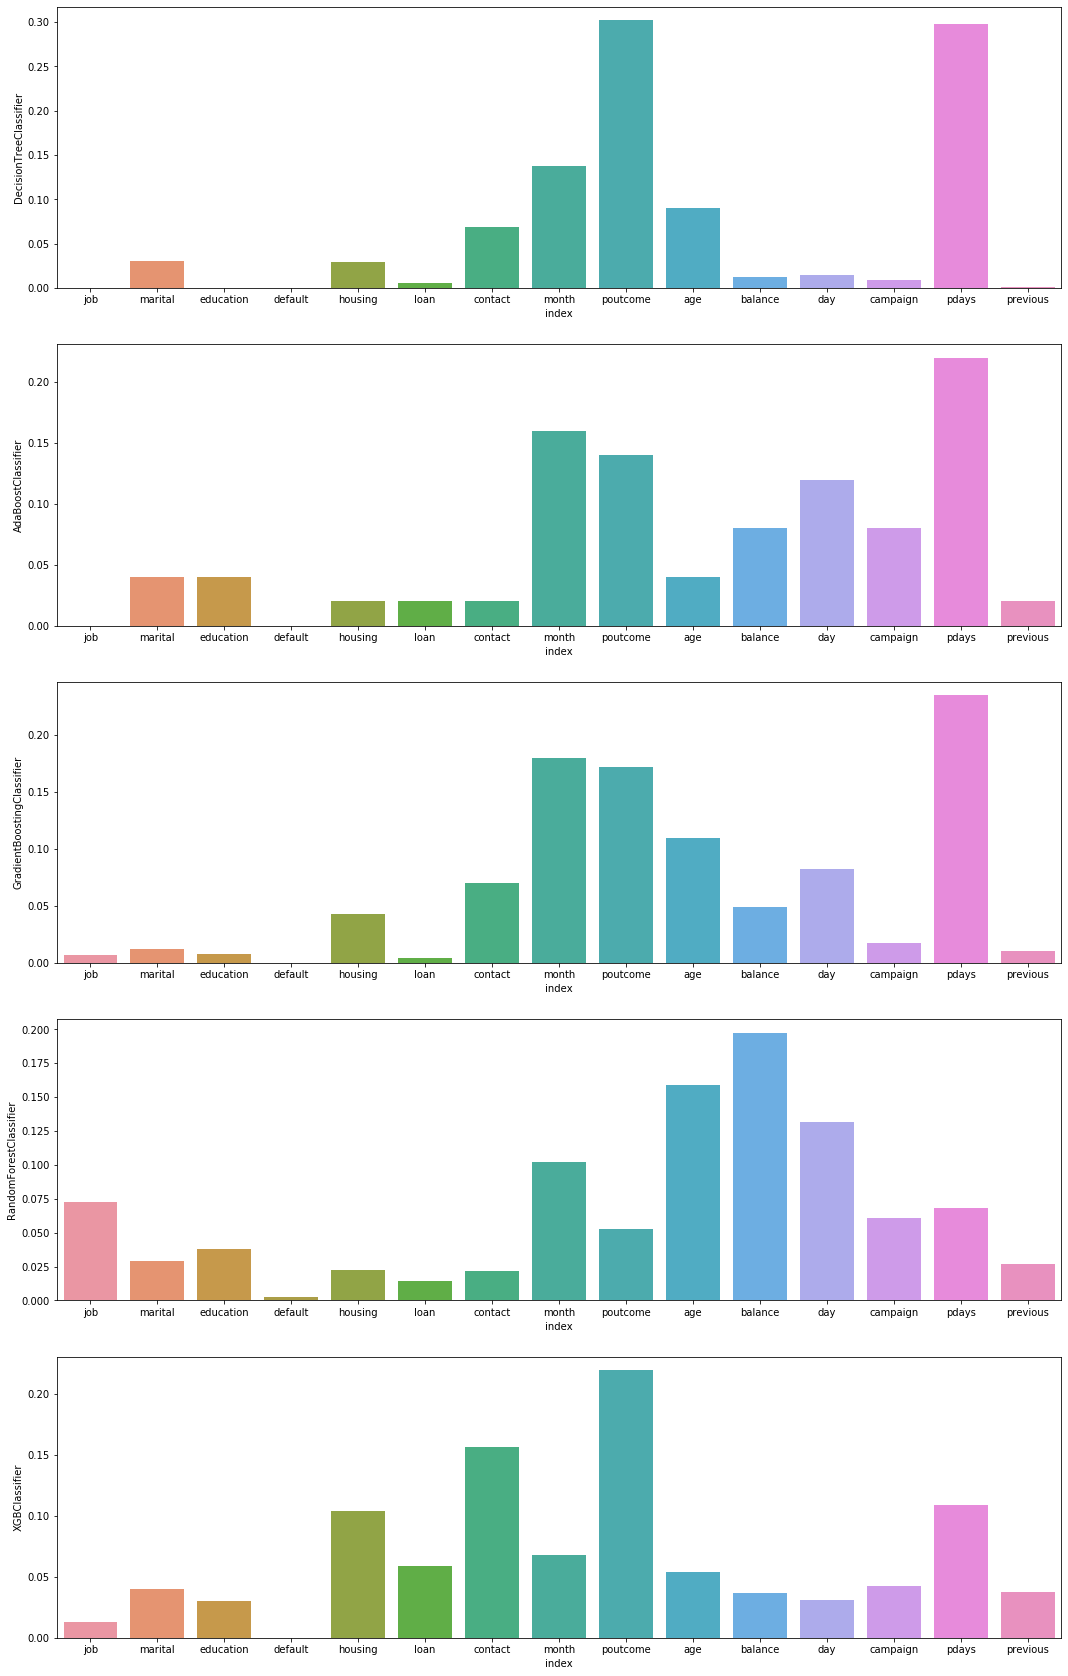

In [26]:
#feature_imp_df.reset_index()

fig, ax = plt.subplots(figsize=(18,30), ncols=1, nrows=5)
sns.catplot(data=feature_imp_df.reset_index(), x='index', y='DecisionTreeClassifier', kind='bar', ax=ax[0])
sns.catplot(data=feature_imp_df.reset_index(), x='index', y='AdaBoostClassifier', kind='bar', ax=ax[1])
sns.catplot(data=feature_imp_df.reset_index(), x='index', y='GradientBoostingClassifier', kind='bar', ax=ax[2])
sns.catplot(data=feature_imp_df.reset_index(), x='index', y='RandomForestClassifier', kind='bar', ax=ax[3])
sns.catplot(data=feature_imp_df.reset_index(), x='index', y='XGBClassifier', kind='bar', ax=ax[4])

# Remove empty axes
plt.close(2)
plt.close(3)
plt.close(4)
plt.close(5)
plt.close(6)

### Analysis
1. Considering all models at once, it appears that poutcome column has most impact while specific algorithms differ in most important features
2. Least impact is seen from the column 'default' which is expected since the data in the column is highly biased

<a id  = precisionRecall></a>
## Precision Recall consideration
At this point, we must consider precision and recall data.

Recall tries to minimize false negatives.
In the given scenario, it is okay to predict that someone might be accepting the term deposit when he might not be but vice versa is not okay. 
Thus our aim would be to maximize the recall value

In [27]:
# Print classification reports
from sklearn.metrics import classification_report
from IPython.display import display, Markdown

for x in classifiers:
    algo = classifiers[x].get_algo()
    display(Markdown('**{}**'.format(type(algo).__name__)))
    print(classification_report(y_test, algo.predict(X_test)))

**LogisticRegression**

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12020
           1       0.65      0.15      0.24      1544

    accuracy                           0.89     13564
   macro avg       0.78      0.57      0.59     13564
weighted avg       0.87      0.89      0.86     13564



**GaussianNB**

              precision    recall  f1-score   support

           0       0.92      0.85      0.88     12020
           1       0.26      0.42      0.33      1544

    accuracy                           0.80     13564
   macro avg       0.59      0.64      0.60     13564
weighted avg       0.85      0.80      0.82     13564



**DecisionTreeClassifier**

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12020
           1       0.55      0.17      0.26      1544

    accuracy                           0.89     13564
   macro avg       0.73      0.58      0.60     13564
weighted avg       0.86      0.89      0.86     13564



**BaggingClassifier**

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     12020
           1       0.54      0.22      0.32      1544

    accuracy                           0.89     13564
   macro avg       0.73      0.60      0.63     13564
weighted avg       0.87      0.89      0.87     13564



**AdaBoostClassifier**

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12020
           1       0.60      0.15      0.24      1544

    accuracy                           0.89     13564
   macro avg       0.75      0.57      0.59     13564
weighted avg       0.87      0.89      0.86     13564



**GradientBoostingClassifier**

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     12020
           1       0.59      0.24      0.34      1544

    accuracy                           0.89     13564
   macro avg       0.75      0.61      0.64     13564
weighted avg       0.87      0.89      0.87     13564



**RandomForestClassifier**

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     12020
           1       0.60      0.22      0.32      1544

    accuracy                           0.89     13564
   macro avg       0.75      0.60      0.63     13564
weighted avg       0.87      0.89      0.87     13564



**XGBClassifier**

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12020
           1       0.62      0.19      0.29      1544

    accuracy                           0.89     13564
   macro avg       0.76      0.59      0.62     13564
weighted avg       0.87      0.89      0.87     13564



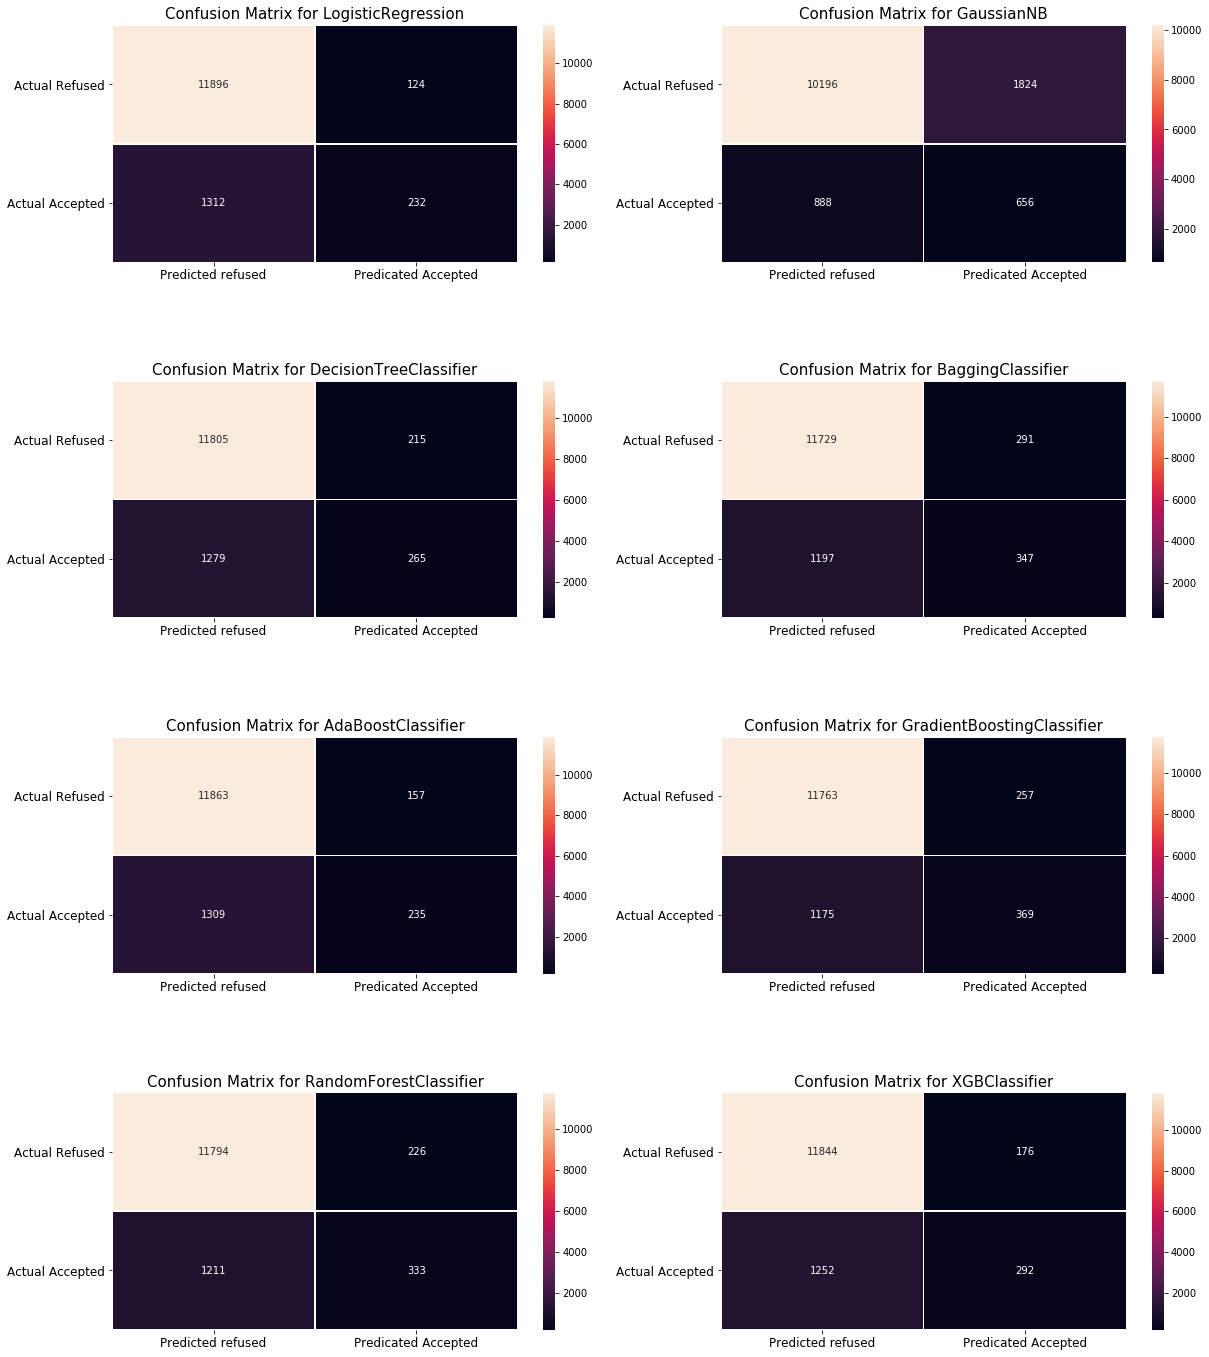

In [28]:
# build confusion matrix
from sklearn.metrics import confusion_matrix
from itertools import chain

fig, ax = plt.subplots(figsize=(20, 24), ncols=2, nrows=4)
plt.subplots_adjust(hspace=0.5)

def print_confustion_matrix(y_true, y_pred, model_name, ax_data):
    matrix = confusion_matrix(y_true, y_pred)
    cnf_map = sns.heatmap(matrix, annot=True, fmt="d", linewidths=.5, ax=ax_data)
    cnf_map.set_title("Confusion Matrix for " + model_name, fontsize=15)
    cnf_map.set_yticks(np.arange(matrix.shape[0]) + 0.5, minor=False)
    cnf_map.set_xticklabels(['Predicted refused', 'Predicated Accepted'], fontsize=12)
    cnf_map.set_yticklabels(['Actual Refused', 'Actual Accepted'], fontsize=12, rotation=360)
    fig.add_subplot(cnf_map)
    
ax_vals = [[(i, 0), (i, 1)] for i in range(len(classifiers)//2+1)]
ax_vals = list(chain(*ax_vals))
counter = 0
    
for x in classifiers:
    model = classifiers[x].get_algo()
    model_name = type(model).__name__
    print_confustion_matrix(y_test, model.predict(X_test), model_name, ax[ax_vals[counter][0]][ax_vals[counter][1]])
    counter += 1

if counter < len(classifiers):
    fig.delaxes(ax[ax_vals[counter][0]][ax_vals[counter][1]]) # Remove the last figure subplot

### Analysis
1. Gausian NB has best recall but overall scores are not optimal as compared to other models
2. Gradient boosting has second best recall and overall performance is acceptable

<a id  = rocCurves></a>
## ROC Curves
Below we compare the ROC curves of various ensemble techniques

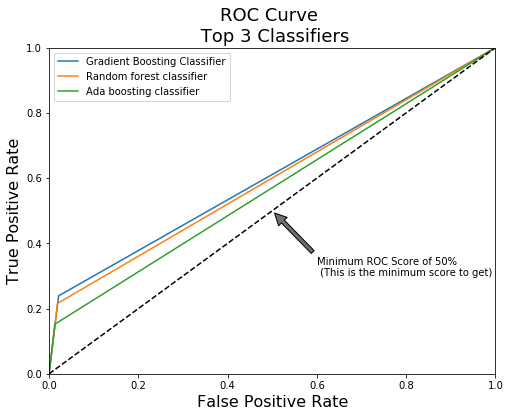

In [29]:
from sklearn.metrics import roc_curve

grd_fpr, grd_tpr, grd_thresold = roc_curve(y_test, classifiers['GradientBoostingClassifier'].get_algo().predict(X_test))
raf_fpr, raf_tpr, raf_threshold = roc_curve(y_test, classifiers['RandomForestClassifier'].get_algo().predict(X_test))
ada_fpr, ada_tpr, ada_threshold = roc_curve(y_test, classifiers['AdaBoostClassifier'].get_algo().predict(X_test))

plt.figure(figsize=(8,6))
plt.title('ROC Curve \n Top 3 Classifiers', fontsize=18)
plt.plot(grd_fpr, grd_tpr, label='Gradient Boosting Classifier')
plt.plot(raf_fpr, raf_tpr, label='Random forest classifier')
plt.plot(ada_fpr, ada_tpr, label='Ada boosting classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
plt.legend();

### Analysis
Above graphs also suggest that ROC scores for Gradient boosting classifier are the best.

<a id  = hyperparameter></a>
## Hyperparameter tuning
Since hyper parameter tuning is a very computation intensive task, we only perform it on the best model so far i.e. Gradient Boosting classifier.
Also, we only select a subset of parameters available.

In [30]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

max_features = list(range(4,X_train.shape[1]))
learning_rates = [0.5, 0.05]
n_estimators = [50, 100, 200]
loss = ['deviance', 'exponential']


param_grid = dict(max_features=max_features,
                  learning_rate=learning_rates,
                  n_estimators=n_estimators,
                  loss=loss
                 )

#Exhaustively check all options -- too slow
# grid = GridSearchCV(estimator=classifiers['GradientBoostingClassifier'].get_algo(),
#                     param_grid=param_grid,
#                     scoring='recall',
#                     verbose=1,
#                     n_jobs=-1)
# grid_result = grid.fit(X_train, y_train)

# print('Best Score: ', grid_result.best_score_)
# print('Best Params: ', grid_result.best_params_)

# Randomly check for certain number of iterations - a bit faster than Grid search
random = RandomizedSearchCV(estimator=classifiers['GradientBoostingClassifier'].get_algo(),
                            param_distributions=param_grid,
                            scoring='recall',
                            verbose=1, n_jobs=-1,
                            n_iter=100, cv=3)
random_result = random.fit(X_train, y_train)

print('Best Score: ', random_result.best_score_)
print('Best Params: ', random_result.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.3min finished


Best Score:  0.25287295141043103
Best Params:  {'n_estimators': 200, 'max_features': 11, 'loss': 'deviance', 'learning_rate': 0.5}


<a id  = stacking></a>
## Stacking with Voting classifier

In [31]:
# Stacking
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[('gbc', classifiers['GradientBoostingClassifier'].get_algo()), 
                ('raf', classifiers['RandomForestClassifier'].get_algo()), 
                ('ada', classifiers['AdaBoostClassifier'].get_algo())],
    voting='soft'
)
voting_clf.fit(X_train, y_train);

In [32]:
from sklearn.metrics import accuracy_score

for clf in (classifiers['GradientBoostingClassifier'].get_algo(), 
            classifiers['RandomForestClassifier'].get_algo(), 
            classifiers['AdaBoostClassifier'].get_algo(), voting_clf):
    clf.fit(X_train, y_train)
    predict = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, predict))

GradientBoostingClassifier 0.894426422884105
RandomForestClassifier 0.8940578000589796
AdaBoostClassifier 0.8919197876732528
VotingClassifier 0.8946475965791801


### Analysis
1. Stacking improves the overall accuracy slightly compared to Gradient Boosting models

<a id  = conclusion></a>
## Conclusions

1. After running several different types of model, we find that Gradient boosting models are best fit for the dataset
2. The bank should focus on following criteria during the campaign <br />
    2.1. Customers that do not have housing loan are more likely to open a term deposit <br />
    2.2. Contact medium should be cellular as much as possible. <br />
    2.3. Customers with tertiary education are more likely to open a term deposit (Percentage of customers opening deposit is more for tertiary than for secondary) <br />
    2.4. Customers with balance less than 20k(approx) are more likely to open term deposit <br />